In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
results_glendale = pd.read_csv("Part_1/Step_0_and_Step_1/glendale_AQI.csv")

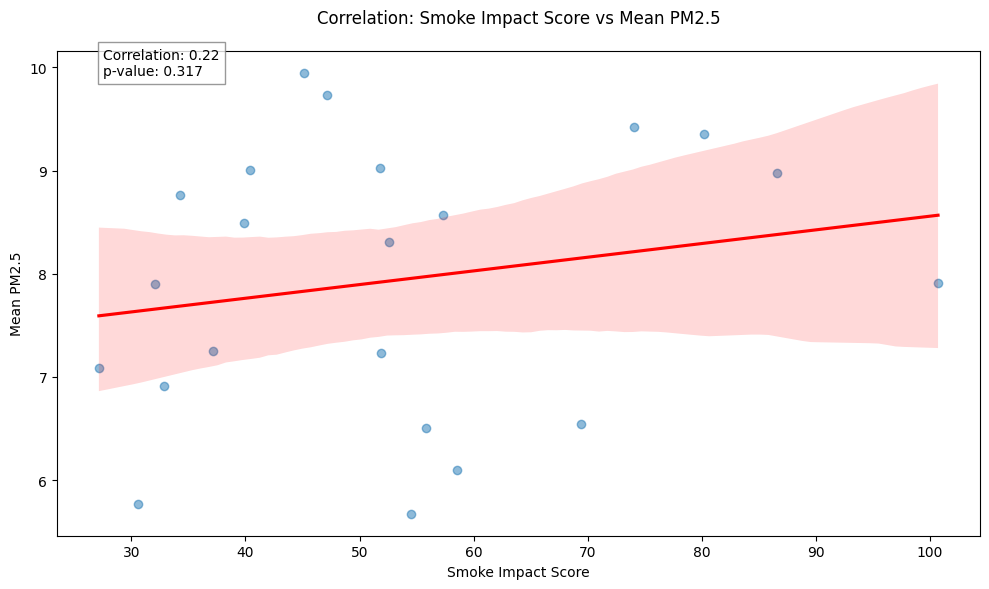

In [36]:
# Calculate correlation coefficient and p-value for smoke_impact_score vs mean_pm25
correlation, p_value = stats.pearsonr(results_glendale['smoke_impact_score'], 
                                    results_glendale['pm25_smoke_score'])

# Create figure and axis
plt.figure(figsize=(10, 6))

# Create scatter plot with regression line
sns.regplot(data=results_glendale, 
            x='smoke_impact_score', 
            y='mean_pm25', 
            scatter_kws={'alpha':0.5}, 
            line_kws={'color': 'red'})

# Add title and labels
plt.title('Correlation: Smoke Impact Score vs Mean PM2.5', pad=20)
plt.xlabel('Smoke Impact Score')
plt.ylabel('Mean PM2.5')

# Add correlation coefficient text
plt.text(0.05, 0.95, 
         f'Correlation: {correlation:.2f}\np-value: {p_value:.3f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

# Adjust layout and display
plt.tight_layout()
plt.show()

# Forecasting

c:\Users\Priyam\anaconda3\envs\Testing\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Priyam\anaconda3\envs\Testing\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Model Metrics:
MSE: 287.3244
RMSE: 16.9506
R2: 0.2073
AIC: 197.4348
BIC: 202.8901
Best ARIMA Order (p,d,q): (1, 0, 2)

Forecast for selected years:
    year        aqi
26  2025  49.716035
31  2030  51.998004
41  2040  52.056635
51  2050  52.056672


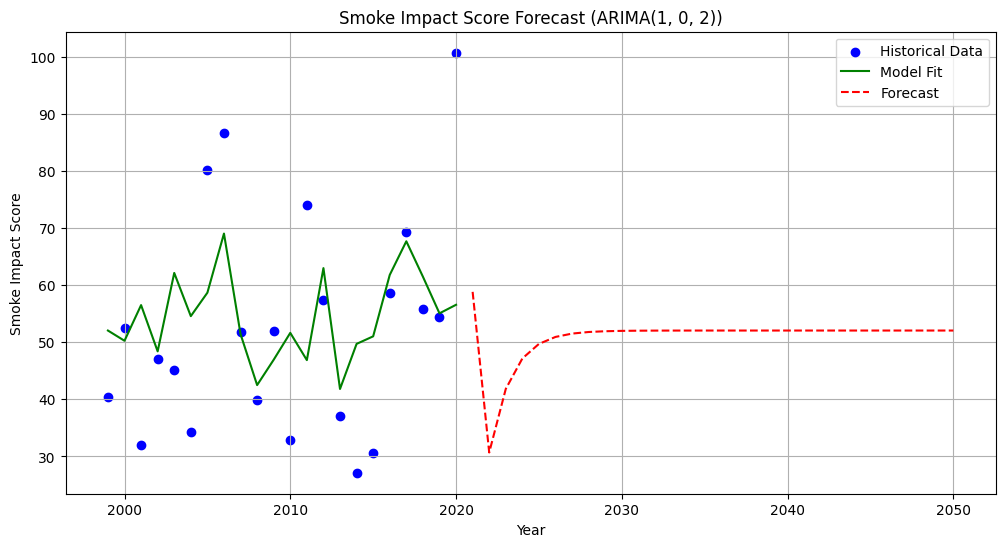

In [50]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pmdarima import auto_arima

def forecast_smoke_impact(df):
    """
    Forecast Smoke Impact Score using ARIMA model.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with 'year' and 'aqi' columns
    
    Returns:
    tuple: (forecast_df, model_metrics, plot)
    """
    # Sort the data by year
    df_filtered = df.sort_values('year')
    
    # Automatically find the best ARIMA parameters
    auto_model = auto_arima(df_filtered['aqi'],
                           start_p=0, start_q=0,
                           max_p=3, max_q=3,
                           m=1,  # no seasonal component
                           d=None,  # let the model determine 'd'
                           seasonal=False,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    
    # Get the order from auto_arima
    best_order = auto_model.order
    
    # Fit the ARIMA model with the best parameters
    model = ARIMA(df_filtered['aqi'], order=best_order)
    results = model.fit()
    
    # Generate predictions for historical period
    historical_pred = results.fittedvalues
    
    # Calculate number of steps to forecast
    last_year = max(df_filtered['year'])
    steps_to_forecast = 2050 - last_year
    
    # Generate future predictions
    forecast = results.forecast(steps=steps_to_forecast)
    
    # Create years array for the entire period
    historical_years = df_filtered['year']
    future_years = np.arange(last_year + 1, 2051)
    all_years = np.concatenate([historical_years, future_years])
    
    # Combine historical and future predictions
    all_predictions = np.concatenate([historical_pred, forecast])
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'year': all_years,
        'aqi': all_predictions
    })
    
    # Calculate metrics
    mse = mean_squared_error(df_filtered['aqi'], historical_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(df_filtered['aqi'], historical_pred)
    aic = results.aic
    bic = results.bic
    
    model_metrics = {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'aic': aic,
        'bic': bic,
        'arima_order': best_order
    }
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot all historical data
    plt.scatter(df_filtered['year'], df_filtered['aqi'], 
               color='blue', label='Historical Data')
    
    # Plot model fit and forecast
    historical_data = forecast_df[forecast_df['year'] <= last_year]
    future_data = forecast_df[forecast_df['year'] > last_year]
    
    plt.plot(historical_data['year'], historical_data['aqi'], 
             color='green', label='Model Fit')
    plt.plot(future_data['year'], future_data['aqi'], 
             color='red', linestyle='--', label='Forecast')
    
    plt.xlabel('Year')
    plt.ylabel('Smoke Impact Score')
    plt.title(f'Smoke Impact Score Forecast (ARIMA{best_order})')
    plt.legend()
    plt.grid(True)
    
    return forecast_df, model_metrics, plt

# Example usage with your data
years = list(results_glendale['year'])
sample_aqi = list(results_glendale['smoke_impact_score'])
df = pd.DataFrame({
    'year': years,
    'aqi': sample_aqi
})

# Run the forecast
forecast_df, metrics, plot = forecast_smoke_impact(df)

# Print results
print("\nModel Metrics:")
for metric, value in metrics.items():
    if metric != 'arima_order':
        print(f"{metric.upper()}: {value:.4f}")
    else:
        print(f"Best ARIMA Order (p,d,q): {value}")

print("\nForecast for selected years:")
selected_years = [2025, 2030, 2040, 2050]
print(forecast_df[forecast_df['year'].isin(selected_years)])